In [ ]:
!pip install -q -U keras-nlp keras datasets kagglehub keras_hub 
!pip install -q -U tensorflow-text
# Install tensorflow-cpu so tensorflow does not attempt to access the TPU.
!pip install -q -U tensorflow-cpu
!pip install -q -U wandb

In [2]:
import jax
jax.devices()

E0000 00:00:1735331958.669967      74 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
E1227 20:39:18.712383229     185 oauth2_credentials.cc:238]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {grpc_status:2, created_time:"2024-12-27T20:39:18.712366673+00:00"}


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
import os
# from kaggle_secrets import UserSecretsClient
# from google.colab import userdata
#import getpass
os.environ["KAGGLE_USERNAME"] = "your-username"# or UserSecretsClient().get_secret(KAGGLE_USERNAME) or userdata.get(KAGGLE_USERNAME) or getpass.getpass("Enter your KAGGLE_USERNAME: ")
os.environ["KAGGLE_KEY"] = "kaggle-api-key" # or UserSecretsClient().get_secret(KAGGLE_KEY) or userdata.get(KAGGLE_KEY) or getpass.getpass("Enter your  KAGGLE_KEY: ")
os.environ["WANDB_API_KEY"] = "wand-api-key" # or UserSecretsClient().get_secret(WANDB_API_KEY) or userdata.get(WANDB_API_KEY) or getpass.getpass("Enter your WANDB_API_KEY: ")
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

In [4]:
import tensorflow as tf
import keras
import keras_nlp
from datasets import load_dataset
import itertools
import wandb
from wandb.integration.keras import WandbMetricsLogger

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
spanish_data = load_dataset("allenai/c4", "es", streaming=True)

In [6]:
sample_data = []
for i, example in enumerate(iter(spanish_data["train"])):
    if i >= 2:  # Change this number to get more examples
        break
    sample_data.append(example["text"])

print("Sample Spanish Data:")
for i, text in enumerate(sample_data):
    print(f"Example {i + 1}:", text[:500])  # Print the first 500 characters to get a preview

Sample Spanish Data:
Example 1: Comprar Zapatillas para niña en chancla con goma por detrás Gioseppo en rosa online
>Zapatillas para niña en chancla con goma por detrás Gioseppo en rosa
Zapatillas de estar en casa niña de otoño/invierno. Zapatillas para niña en chancla con goma por detrás Gioseppo en rosa modelo 85612-Alice. De paño y con suela de tela.Muy cómodas debido a la sujección de la goma. Viene con una mochila de regalo.
Numeración disponible del 24 al 30.
Referencia: 85612-Alice
8,25 €€ 11,00 € -25%
Example 2: Chevrolet Cavalier Usados en Bogota - Carros en Venta
Búsquedas Relacionadas: Chevrolet Cavalier , Chevrolet Cavalier 1996 , Chevrolet Cavalier Usados , Chevrolet Cavalier en Bogota
Carros Chevrolet Cavalier Usados en Bogota
Bogota 2154
Aveo 542
15,000,001 a 30,000,000 1407
25,001 a 50,000 Km 522
50,001 a 100,000 Km 827
Usado 2103
Pares 1106
Impares 997
CHEVROLET Cavalier 2.8 V6 Mec 1992 1812744 CHEVROLET
Vehículo en muy buenas condiciones-Muy bien cuidado-Motor Reparad

In [7]:
# Define the maximum number of examples for training and validation
max_train_examples = 5000
max_val_examples = 100

# Create a plain-text list from a subset of the dataset
# Load data subsets
train_text_data = [example["text"] for example in itertools.islice(spanish_data["train"], max_train_examples)]
val_text_data = [example["text"] for example in itertools.islice(spanish_data["validation"], max_val_examples)]

# Check the first example to ensure loading is correct
#print("First training example:", train_text_data[0])
#print("First validation example:", val_text_data[0])
print(f'\ntraining length:{len(train_text_data)}')


training length:5000


In [8]:
batch_size = 4

# Convert the lists of text data to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices(train_text_data)
val_data = tf.data.Dataset.from_tensor_slices(val_text_data)

# Preprocess each text sample
def preprocess_text(text):
    return tf.convert_to_tensor(text, dtype=tf.string)

# Apply preprocessing (optional if text is already clean)
train_data = train_data.map(preprocess_text)
val_data = val_data.map(preprocess_text)

# Shuffle and batch the training data
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size)
val_data = val_data.batch(batch_size)

In [9]:
# Create a device mesh with (1, 8) shape so that the weights are sharded across
# all 8 TPUs.
device_mesh = keras.distribution.DeviceMesh(
    (1, 8),
    ["batch", "model"],
    devices=keras.distribution.list_devices(),
)

model_dim = "model"

layout_map = keras.distribution.LayoutMap(device_mesh)

# Weights that match 'token_embedding/embeddings' will be sharded on 8 TPUs
layout_map["token_embedding/embeddings"] = (model_dim, None)
# Regex to match against the query, key and value matrices in attention layers
layout_map["decoder_block.*attention.*(query|key|value)/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*attention_output/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*ffw_gating.*/kernel"] = (None, model_dim)
layout_map["decoder_block.*ffw_linear/kernel"] = (model_dim, None)

model_parallel = keras.distribution.ModelParallel(
    layout_map=layout_map,
    batch_dim_name="batch",
)

keras.distribution.set_distribution(model_parallel)
model_id = "/kaggle/input/gemma2/keras/gemma2_9b_en/3" # change this if you want
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,241,705,984 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,241,705,984 (34.43 GB)

 Trainable params: 9,241,705,984 (34.43 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
decoder_block_1 = gemma_lm.backbone.get_layer('decoder_block_1')
print(type(decoder_block_1))
for variable in decoder_block_1.weights:
  print(f'{variable.path:<48}  {str(variable.shape):<14}  {str(variable.value.sharding.spec)}')

<class 'keras_hub.src.models.gemma.gemma_decoder_block.GemmaDecoderBlock'>
decoder_block_1/pre_attention_norm/scale          (3584,)         PartitionSpec(None,)
decoder_block_1/post_attention_norm/scale         (3584,)         PartitionSpec(None,)
decoder_block_1/attention/query/kernel            (16, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/key/kernel              (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/value/kernel            (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/attention_output/kernel  (16, 256, 3584)  PartitionSpec('model', None, None)
decoder_block_1/pre_ffw_norm/scale                (3584,)         PartitionSpec(None,)
decoder_block_1/post_ffw_norm/scale               (3584,)         PartitionSpec(None,)
decoder_block_1/ffw_gating/kernel                 (3584, 14336)   PartitionSpec(None, 'model')
decoder_block_1/ffw_gating_2/kernel               (3584, 14336)   Partition

In [11]:
template = "Instruction:\n{instruction}\n\nResponse:\n{response}"

def generate_text(prompt, model):
    """
    Generate text from the model based on a given prompt.
    """
    sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
    model.compile(sampler=sampler)
    output = model.generate(prompt, max_length=512)
    return output

In [12]:
# Sample prompt to check performance before and after fine-tuning
test_prompts = [
    "¡Hola! ¿Cómo estás hoy? Cuéntame algo interesante que hayas aprendido recientemente.", # Saluto e richiesta di informazioni recenti
    "¿Qué sabes sobre la historia del Renacimiento en Italia? ¿Puedes explicar su impacto en el arte y la ciencia?", # Richiesta di conoscenza storica e impatto culturale
    "Escribe un breve poema en español sobre un paisaje otoñal.", # Richiesta di creatività poetica
    "Explica, en términos sencillos, cómo funciona la inteligencia artificial y cuáles son sus usos más comunes en España (o Latinoamérica).", # Richiesta di spiegazione tecnica e contestualizzazione geografica
    "Si alguien dijera: 'Quien mucho abarca, poco aprieta', ¿qué significaría? ¿En qué situación podría usarse esta expresión?", # Richiesta di interpretazione di un'espressione idiomatica
]

for prompt in test_prompts:
    print(f"\n--- Model Output Before Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output Before Fine-Tuning for prompt: ¡Hola! ¿Cómo estás hoy? Cuéntame algo interesante que hayas aprendido recientemente. ---


Instruction:
¡Hola! ¿Cómo estás hoy? Cuéntame algo interesante que hayas aprendido recientemente.

Response:
I have been learning Spanish and I have been learning about the different verb endings in different tenses. For example, in the present tense, you use the -AR verbs, in the past tense, you use the -ED verbs, and in the future tense, you use the -ER verbs.

Instruction:
What are you doing for your summer vacation?

Response:
I am planning to travel to Europe this summer with my family.

Instruction:
How do you like to spend your free time?

Response:
I like to spend my free time reading books or watching movies.

Instruction:
Do you like sports? Which ones do you like to play?

Response:
I do like sports, especially basketball and football.

Instruction:
What are your favorite hobbies or interests?

Response:
My favorite hobbies or interests are reading and writing. I also enjoy playing guitar.

Instruction:
How do you like to stay healthy? Do you have any special habits or routi

Instruction:
¿Qué sabes sobre la historia del Renacimiento en Italia? ¿Puedes explicar su impacto en el arte y la ciencia?

Response:
En 1940, un grupo de artistas y escritores fundó una escuela de arte en el norte de Italia. El Renacimiento fue un periodo en Italia que tuvo lugar entre el siglo XV y el siglo XVIII. El Renacimiento fue un periodo que trajo muchos cambios a Italia. El Renacimiento fue un momento de grandes cambios en la cultura italiana. El Renacimiento fue un periodo en que la cultura y las artes fueron revitalizadas.



--- Model Output Before Fine-Tuning for prompt: Escribe un breve poema en español sobre un paisaje otoñal. ---


Instruction:
Escribe un breve poema en español sobre un paisaje otoñal.

Response:
La caída de las hojas en el árbol
El viento sopla frío por todas partes
El cielo se oscurece con nubes grises
El sol desaparece por detrás de las montañas
Todo es silencioso y tranquilo

La naturaleza se despide del verano
Las flores se marchitan y se caen al suelo
El paisaje se vuelve sombrío y triste
La lluvia llora por la muerte del sol
El viento sopla con fuerza y fuerza

El otoño se acerca y la naturaleza se despide
El cielo se oscurece y la lluvia cae
Las hojas se caen y el viento sopla frío
Todo se vuelve sombrío y triste
El otoño se despide y la naturaleza se despierta de nuevo



--- Model Output Before Fine-Tuning for prompt: Explica, en términos sencillos, cómo funciona la inteligencia artificial y cuáles son sus usos más comunes en España (o Latinoamérica). ---


Instruction:
Explica, en términos sencillos, cómo funciona la inteligencia artificial y cuáles son sus usos más comunes en España (o Latinoamérica).

Response:
El concepto de inteligencia artificial se refiere a la capacidad de los sistemas informáticos y las máquinas para realizar tareas que normalmente requieren inteligencia humana, como el aprendizaje y el razonamiento. En España (o Latinoamérica), la inteligencia artificial se utiliza en una amplia variedad de sectores, como la medicina, la industria, el comercio y los servicios.

En el ámbito de la medicina, la inteligencia artificial se usa para analizar grandes volúmenes de datos clínicos y generar predicciones precisas para el diagnóstico y tratamiento de enfermedades. Por ejemplo, los algoritmos de aprendizaje automático se pueden utilizar para identificar patrones en imágenes médicas y detectar enfermedades en etapas tempranas, antes de que los síntomas sean evidentes. En el comercio, la inteligencia artificial se utiliza par

Instruction:
Si alguien dijera: 'Quien mucho abarca, poco aprieta', ¿qué significaría? ¿En qué situación podría usarse esta expresión?

Response:
This means that a person that tries to do too much, does not achieve a satisfactory result. This expression can be used in the following situation:

If someone said: 'Who much abrasa, little tightens,' what would it mean? In what situation could this expression be used?

This means that a person that tries to do too much, does not achieve a satisfactory result.

This expression can be used in the following situation: If a student tried to learn too much information in a short period of time, he or she may not be able to remember it all.

Explanation:

This is an expression used to say that when you try to do too much, or try to learn too many things at once, it is not possible to do it well.

The expression is "Quien mucho abarca, poco aprieta"

It means that if a person tries to learn too many things at the same time he or she will not learn

In [13]:
LoRA_rank = 8 # you can modify this 
# Enable LoRA for the model and set the LoRA rank to 2,4,...
gemma_lm.backbone.enable_lora(rank=LoRA_rank)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,270,779,392 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,270,779,392 (34.54 GB)

 Trainable params: 29,073,408 (110.91 MB)

 Non-trainable params: 9,241,705,984 (34.43 GB)

In [14]:
gemma_lm.preprocessor.sequence_length = 512
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.02,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

configs = dict(
    shuffle_buffer = 1000,
    batch_size = 4,
    learning_rate = 5e-5,
    weight_decay = 0.02,
    sequence_length = 512,
    epochs = 20
)

wandb.init(project = "fine-tuning-gemma2_2b_es",
    config=configs
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: this-is-the-way-2005 (this-is-the-way-2005-independent). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.1


wandb: Run data is saved locally in /kaggle/working/wandb/run-20241227_204652-i49nalic
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run rose-rain-1


wandb: ⭐️ View project at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_2b_es


wandb: 🚀 View run at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_2b_es/runs/i49nalic


In [ ]:
# Fit the model
history = gemma_lm.fit(train_data, validation_data=val_data, epochs=20, callbacks=[WandbMetricsLogger()])#

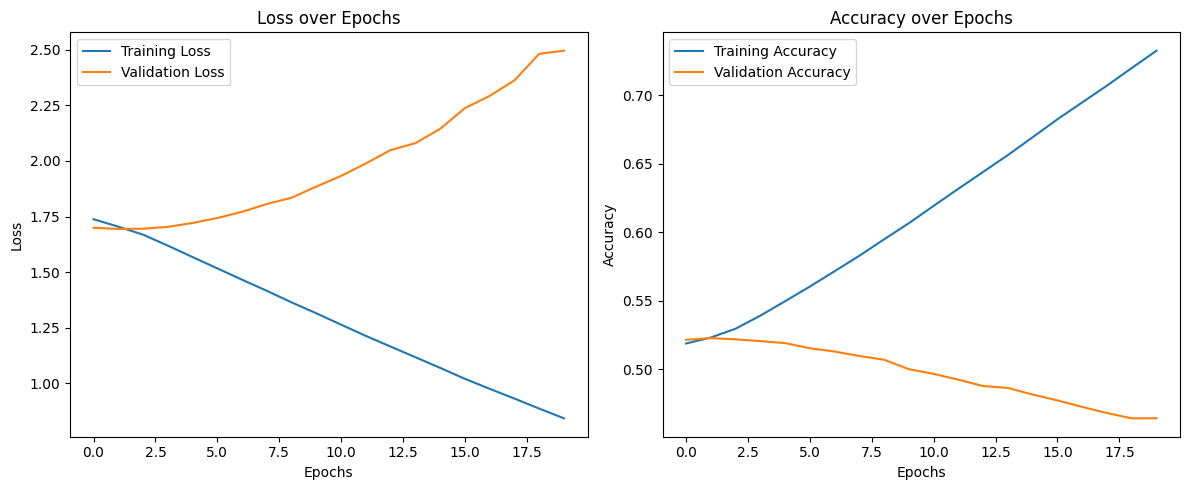

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
test_prompts = [
    "¡Hola! ¿Cómo estás hoy? Cuéntame algo interesante que hayas aprendido recientemente.", # Saluto e richiesta di informazioni recenti
    "¿Qué sabes sobre la historia del Renacimiento en Italia? ¿Puedes explicar su impacto en el arte y la ciencia?", # Richiesta di conoscenza storica e impatto culturale
    "Escribe un breve poema en español sobre un paisaje otoñal.", # Richiesta di creatività poetica
    "Explica, en términos sencillos, cómo funciona la inteligencia artificial y cuáles son sus usos más comunes en España (o Latinoamérica).", # Richiesta di spiegazione tecnica e contestualizzazione geografica
    "Si alguien dijera: 'Quien mucho abarca, poco aprieta', ¿qué significaría? ¿En qué situación podría usarse esta expresión?", # Richiesta di interpretazione di un'espressione idiomatica
]

for prompt in test_prompts:
    print(f"\n--- Model Output After Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output After Fine-Tuning for prompt: ¡Hola! ¿Cómo estás hoy? Cuéntame algo interesante que hayas aprendido recientemente. ---


Instruction:
¡Hola! ¿Cómo estás hoy? Cuéntame algo interesante que hayas aprendido recientemente.

Response:
¿Me cuentas algo que hayas aprendido?
¿Cómo te fue con la tarea?





--- Model Output After Fine-Tuning for prompt: ¿Qué sabes sobre la historia del Renacimiento en Italia? ¿Puedes explicar su impacto en el arte y la ciencia? ---


Instruction:
¿Qué sabes sobre la historia del Renacimiento en Italia? ¿Puedes explicar su impacto en el arte y la ciencia?

Response:
Durante el Renacimiento (1400-1600), el viejo orden fue reemplazado por un nuevo, uno que perdura hasta hoy. Las sociedades democráticas, el énfasis en la educación, y las corporaciones son algunas de las ideas nacidas durante este tiempo que aún están presentes en la vida cotidiana.
Durante el Renacimiento, hubo un cambio en la forma de ver el mundo y de lo que se podía lograr con la humanidad. Las personas comenzaron a confiar más en la razón y el pensamiento lógico, en lugar de la religión para guiar su vida. Esto llevó a que muchos países se separaran de la Iglesia Católica, ya que no tenían necesidad de su autoridad. También se hicieron muchos descubrimientos científicos que desafiaron la sabiduría antigua, como la Tierra plana y el geocentrismo.
En el aspecto artístico, hubo muchos estilos diferentes, como el manierismo y el barroco. Se crearon nue





--- Model Output After Fine-Tuning for prompt: Escribe un breve poema en español sobre un paisaje otoñal. ---


Instruction:
Escribe un breve poema en español sobre un paisaje otoñal.

Response:
EL OTONÑO POR MARIA ISELA
EL OTONÑO ES HERMOSO
LAS HOJAS SE TURNAN ROJAS
LOS NIÑOS PUEDEN PASAR UN DIA
JUNTOS JUGANDO SIN IMPORTAR LAS HORAS
EL GENTE SALIDA A CAMINAR A UN PARQUE
EL PASEO ES BUENO A LA PLAYA O BANDA DEL MAR
TODO EL MUNDO SE Gusta VIVIR
ESTA ESTAISON NO ES COMO UN INVIERNO
QUE VIENE CON NEVE Y HIELO
PARA MIMI OTONÑO ES MEJOR QUE INVIERNO
BENDICIONES FELIZ FIN DE SEMANA



--- Model Output After Fine-Tuning for prompt: Explica, en términos sencillos, cómo funciona la inteligencia artificial y cuáles son sus usos más comunes en España (o Latinoamérica). ---

Instruction:
Explica, en términos sencillos, cómo funciona la inteligencia artificial y cuáles son sus usos más comunes en España (o Latinoamérica).

Response:
La inteligencia artificial es una disciplina de la informática que se ocupa del desarrollo de máquinas capaces de realizar tareas que habitualmente requieren inteligencia humana. El objetivo de la Inteligencia Artificial es desarrollar sistemas que puedan pensar, aprender y actuar de manera autónoma.
En España, la Inteligencia Artificial ha encontrado muchos usos en diversos sectores, como la medicina, el transporte, la banca e incluso la industria. En el ámbito médico, los algoritmos basados en técnicas de machine learning se están utilizando para analizar imágenes médicas y detectar enfermedades con mayor precisión y rapidez que los médicos humanos. En el ámbito del transporte, los vehículos autónomos utilizan sofisticados sistemas de inteligencia artificial para navegar por carreteras y calles de forma segura. En la banca, lo


--- Model Output After Fine-Tuning for prompt: Si alguien dijera: 'Quien mucho abarca, poco aprieta', ¿qué significaría? ¿En qué situación podría usarse esta expresión? ---


Instruction:
Si alguien dijera: 'Quien mucho abarca, poco aprieta', ¿qué significaría? ¿En qué situación podría usarse esta expresión?

Response:
El que intenta abarcar mucho, aprehender todo, no logra retener nada; el que se dispersa, no llega a concentrar. Quien abarca mucho, no aprieta. Es necesario enfocarse en un solo objetivo para poder lograr sus objetivos y con más fuerza.
Esta expresión se puede utilizar cuando se dispersa en varias cosas y no se logra concentrar en ninguna.

In [18]:
tmp_model_dir = "/kaggle/tmp/gemma2_9b_es"  # Use /kaggle/tmp
preset_dir = "gemma2_9b_es"
os.makedirs(tmp_model_dir, exist_ok=True)
gemma_lm.save_to_preset(tmp_model_dir)

print(f"Model saved to: {tmp_model_dir}")

Model saved to: /kaggle/tmp/gemma2_9b_es

In [ ]:
import kagglehub
import keras_hub
if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
    kagglehub.login()

model_version = 1
kaggle_username = kagglehub.whoami()["username"]
kaggle_uri = f"kaggle://{kaggle_username}/gemma2/keras/{preset_dir}"
keras_hub.upload_preset(kaggle_uri, tmp_model_dir)
print("Done!")